In [2]:
#Import Libraries
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pandas as pd
from statsmodels.tsa.stattools import adfuller, acf, pacf
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
#Downloading Dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggl
!kaggle datasets download -d fedesoriano/traffic-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/traffic-prediction-dataset
License(s): copyright-authors
  0% 0.00/277k [00:00<?, ?B/s]
100% 277k/277k [00:00<00:00, 79.9MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/traffic-prediction-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
#Load Data
traffic_data=pd.read_csv('traffic.csv')
traffic_data

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


In [6]:
# Parse the DateTime column
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

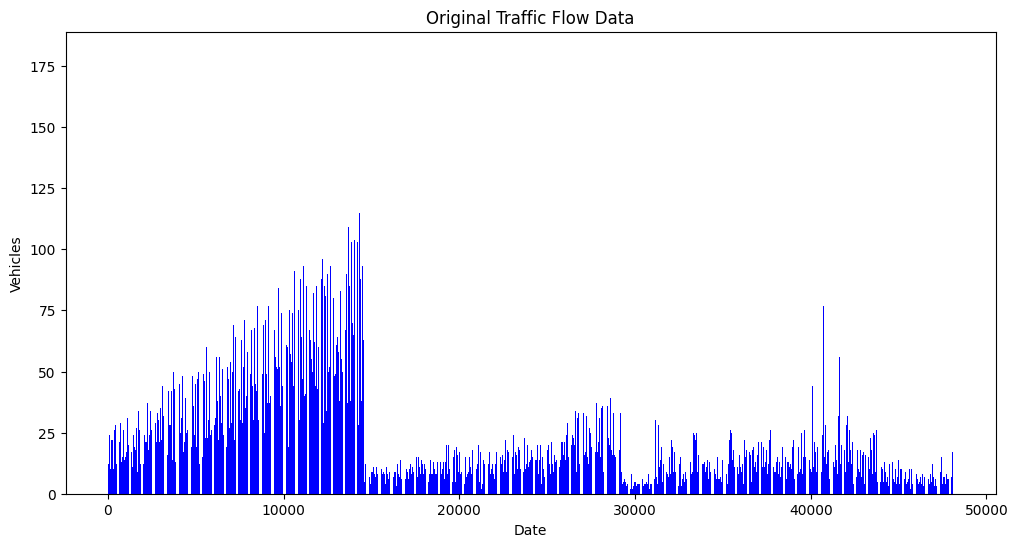

In [7]:
# Plot the original traffic flow data
plt.figure(figsize=(12, 6))
plt.bar(traffic_data.index, traffic_data['Vehicles'], color='blue')
plt.title('Original Traffic Flow Data')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.show()

In [8]:
# Parse the DateTime column and filter data for a single junction
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
junction_data = traffic_data[traffic_data['Junction'] == 1].set_index('DateTime')

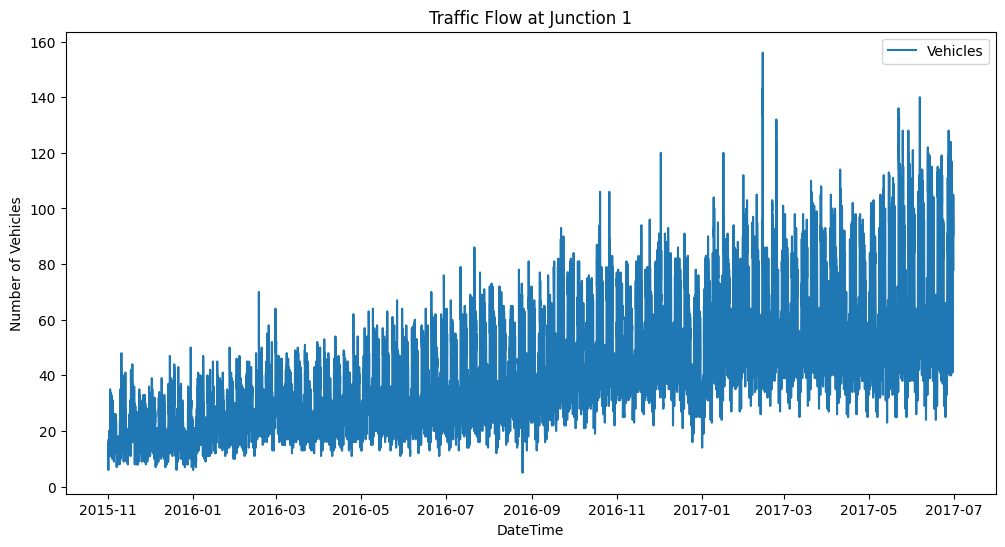

In [9]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(junction_data['Vehicles'], label='Vehicles')
plt.title('Traffic Flow at Junction 1')
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

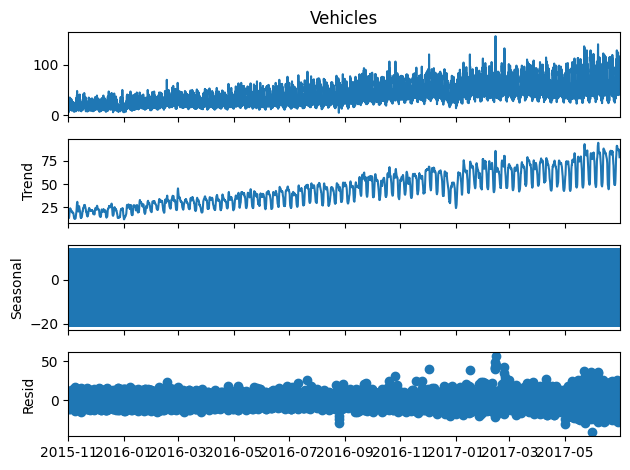

In [10]:
# Decompose the time series
decomposition = seasonal_decompose(junction_data['Vehicles'], model='additive', period=24)
decomposition.plot()
plt.show()

In [12]:
#Split the data into training and testing sets
train_data = junction_data['Vehicles'][:int(0.8*len(junction_data))]
test_data = junction_data['Vehicles'][int(0.8*len(junction_data)):]

In [13]:
#Fit the SARIMA model
sarima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
sarima_fit = sarima_model.fit(disp=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [14]:
# Make predictions
predictions = sarima_fit.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=False)


In [16]:
# DataFrame for pairplot visualization
results_df = pd.DataFrame({
    'DateTime': test_data.index,
    'Actual': test_data.values,
    'Predicted': predictions.values
})

# Merge training data into the DataFrame for a complete view
train_df = pd.DataFrame({
    'DateTime': train_data.index,
    'Actual': train_data.values,
    'Predicted': [None]*len(train_data)
})


full_df = pd.concat([train_df, results_df])

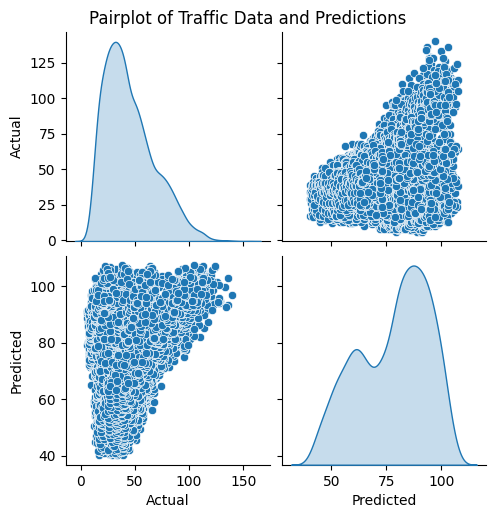

In [17]:
# Plot the pairplot
sns.pairplot(full_df, diag_kind='kde')
plt.suptitle('Pairplot of Traffic Data and Predictions', y=1.02)
plt.show()

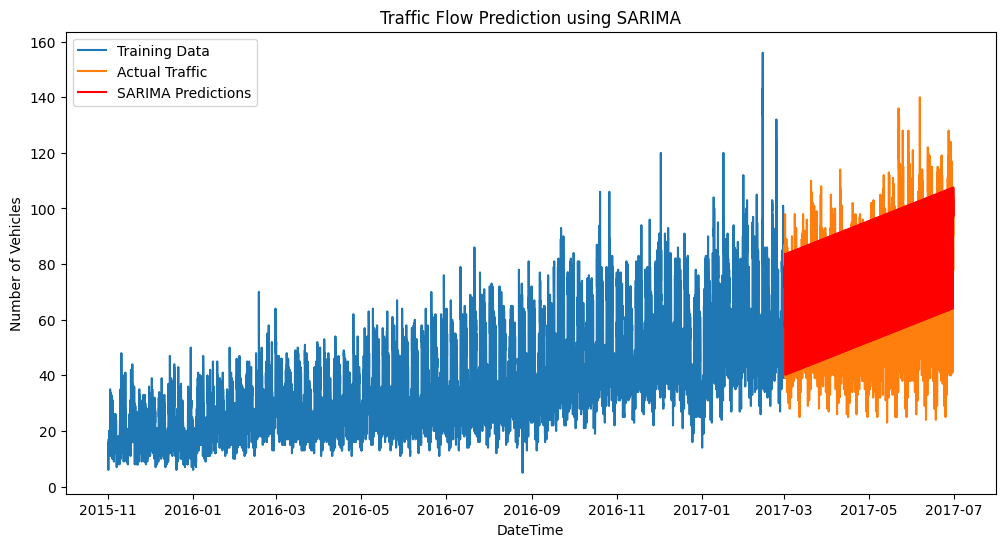

In [18]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Traffic')
plt.plot(predictions, label='SARIMA Predictions', color='red')
plt.title('Traffic Flow Prediction using SARIMA')
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

In [19]:
# Calculate and print the Mean Squared Error
mse = mean_squared_error(test_data, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 371.04412175838144
